# Shor's Algorithm 
We will implement Shor's Algorithm to factor the number 15. 

Shor's algorithm can be used to factor numbers $N$ that are products of the form 

$$N = pq$$

where $p$ and $q$ are prime numbers. We will use two registers of qubits. The first register will have $n$ qubits, and will contain the measurement qubits. The second register will have $m$ qubits, and will be the eigenstate for quantum phase estimation.

1. Initializing our qubits: We create a superposition of all $2^n$ computational basis states on the $n$ measurement qubits by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. We also initialize the $m$ target qubits in the state $\vert1\rangle$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits.

2. We apply the unitary operator $U$ with various powers onto the target qubits by controlling it with each of the different measurement qubits. The unitary operator in this case implements modular exponentiation. 

3. We apply an inverse quantum Fourier transform on the $n$ measurement qubits.

4. Measuring the first $n$ qubits. 

After the measurement outcomes are determined, we will need to do additional classical post-processing in order to determine the factors

## Initializing the qubits
We can initialize our qubits by applying a Hadamard gate on each of the $n$ measurement qubits. We will also set the target qubits to $\vert1\rangle$, since that is the eigenstate onto which the unitary operator $U$ will be applied. Here, $\vert1\rangle$ is initialized by applying an $X$ gate on the last qubit.

In [3]:
!pip install -U -r resources/requirements.txt

from IPython.display import clear_output
clear_output()

In [4]:
def initialize_qubits(given_circuit, n, m):
    given_circuit.h(range(n))
    given_circuit.x(n+m-1)

## Modular exponentiation
We will create a function called a_x_mod15 which takes in two arguments, $a$ and $x$, and implements the unitary operator $$U = a^x \text{ mod } 15$$



In [5]:
from qiskit import QuantumCircuit

def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U

/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zeros(len(label), dtype=np.bool)
/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/quantum_info/operators/pauli.py:112: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros(len(label

The above function creates a 4-qubit unitary controlled by an additional fifth qubit. In order to use this gate, you will need to append it to our quantum circuit. 

We will then create a function called `modular_exponentiation` which takes in 4 arguments. The first argument, `given_circuit`, is the circuit onto which modular exponentiation will be applied. The next two arguments, $n$ and $m$, are the numbers of measurement and target qubits.

In [6]:
def modular_exponentiation(given_circuit, n, m, a):
    for x in range(n):
        exponent = 2**x
        given_circuit.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))    

## Implementing the inverse quantum Fourier transform

The function `apply_iqft` takes two arguments. The first argument, `given_circuit`, contains the qubits onto which the inverse quantum Fourier transform will be applied. The second argument, `measurement_qubits`, contains the list of qubits onto which the inverse quantum Fourier transform will be applied.

In [7]:
from qiskit.circuit.library import QFT

In [8]:
def apply_iqft(given_circuit, measurement_qubits):    
    given_circuit.append(QFT( len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)

In [9]:
from qiskit import QuantumCircuit

In [10]:
def shor_program(n, m, a):
    
    # set up quantum circuit
    shor = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(shor, n, m)
    shor.barrier()

    # apply modular exponentiation
    modular_exponentiation(shor, n, m, a)
    shor.barrier()

    # apply inverse QFT
    apply_iqft(shor, range(n))

    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor
    
n = 4; m = 4; a = 7
mycircuit = shor_program(n, m, a)
mycircuit.draw()

/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the

/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the

┌───┐ ░                                                              ░ »
q_0: ┤ H ├─░────────■─────────────────────────────────────────────────────░─»
     ├───┤ ░        │                                                     ░ »
q_1: ┤ H ├─░────────┼──────────────■──────────────────────────────────────░─»
     ├───┤ ░        │              │                                      ░ »
q_2: ┤ H ├─░────────┼──────────────┼──────────────■───────────────────────░─»
     ├───┤ ░        │              │              │                       ░ »
q_3: ┤ H ├─░────────┼──────────────┼──────────────┼──────────────■────────░─»
     └───┘ ░ ┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐┌─────┴┼──────┐ ░ »
q_4: ──────░─┤0     │      ├┤0     │      ├┤0     │      ├┤0     │      ├─░─»
           ░ │             ││             ││             ││             │ ░ »
q_5: ──────░─┤1            ├┤1            ├┤1            ├┤1            ├─░─»
           ░ │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 │ ░ »
q_6: ──────░─┤2            ├┤2            ├┤2            ├┤2            ├─░─»
     ┌───┐ ░ │             ││             ││             ││             │ ░ »
q_7: ┤ X ├─░─┤3            ├┤3            ├┤3            ├┤3            ├─░─»
     └───┘ ░ └─────────────┘└─────────────┘└─────────────┘└─────────────┘ ░ »
c: 4/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«     ┌───────┐┌─┐         
«q_0: ┤0      ├┤M├─────────
«     │       │└╥┘┌─┐      
«q_1: ┤1      ├─╫─┤M├──────
«     │  iqft │ ║ └╥┘┌─┐   
«q_2: ┤2      ├─╫──╫─┤M├───
«     │       │ ║  ║ └╥┘┌─┐
«q_3: ┤3      ├─╫──╫──╫─┤M├
«     └───────┘ ║  ║  ║ └╥┘
«q_4: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_5: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_6: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«q_7: ──────────╫──╫──╫──╫─
«               ║  ║  ║  ║ 
«c: 4/══════════╩══╩══╩══╩═
«               0  1  2  3

/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the

/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the

/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(key, (int, np.int, np.int32, np.int64, slice, list)):
/home/sushmitha/anaconda3/lib/python3.9/site-packages/qiskit/circuit/register.py:121: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the

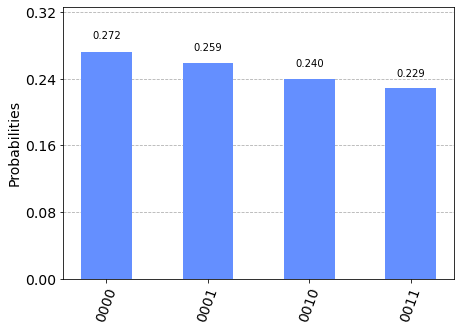

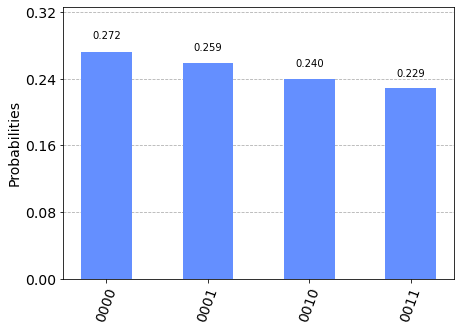

In [11]:
#running the quantum circuit 
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [12]:
for measured_value in counts:
    print(f"Measured {int(measured_value[::-1], 2)}")

Measured 0
Measured 8
Measured 4
Measured 12


## Classical post-processing 
In order to factor the number $N = pq$, we use a number $a$ coprime with $N$ and compute the period of $a^x \text{ mod } N$.

In [13]:
from math import gcd

for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Measured {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Failed. Measured value is not an even number")
        continue
    x = int((a ** (measured_value_decimal/2)) % 15)
    if (x + 1) % 15 == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    print(guesses)

Measured 0
(1, 15)
Measured 8
(1, 15)
Measured 4
(5, 3)
Measured 12
(5, 3)
